<a href="https://colab.research.google.com/github/VMBoehm/DeNoPa/blob/master/TrainNVP_and_measure_Reconstruction_Noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
import sys
import pickle
 
plt.rcParams.update({'font.family' : 'lmodern', 'font.size': 16,                                                                                                                                                    
                     'axes.labelsize': 16, 'legend.fontsize': 12, 
                     'xtick.labelsize': 16, 'ytick.labelsize': 16, 'axes.titlesize': 16,
                     'axes.linewidth': 1.5}) 

In [14]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors

In [15]:
sys.path.append('../')
from vae.model import get_prior, get_posterior, get_likelihood


In [16]:
import vae.create_datasets as crd
import vae.load_data as ld
from functools import partial
load_funcs=dict(mnist=ld.load_mnist, fmnist=ld.load_fmnist, cifar10=ld.load_cifar10, sn=ld.load_sn_lightcurves)


In [17]:
data_sets  = ['mnist','fmnist']

In [18]:
likelihood  = 'Gauss'
class_label = -1
network_type= 'fully_connected'
latent_size = 8
AE          = False
batch_size  = 512

In [19]:
params={}
module_dirs={}
for data_set in data_sets:
    if AE:
        param = pickle.load(open('../params/params_%s_%s_%d_%d_%s-AE.pkl'%(data_set,likelihood,class_label,latent_size, network_type),'rb'))
    else:
        param = pickle.load(open('../params/params_%s_%s_%d_%d_%s.pkl'%(data_set,likelihood,class_label,latent_size,network_type),'rb'))
    module_dirs[data_set]= param['module_dir']
    param['add_noise']=False
    param['batch_size']=1
    params[data_set]=param

In [20]:
generator_path ={}
encoder_path   ={} 
nvp_path       ={}
for jj,dataset in enumerate(data_sets):
    module_dir       = os.path.join(module_dirs[dataset],'vae')
    all_subdirs      = [os.path.join(module_dir,d) for d in os.listdir(module_dir+'/') if os.path.isdir(os.path.join(module_dir,d))]
    latest_subdir    = max(all_subdirs, key=os.path.getmtime)
    generator_path[dataset] = os.path.join(latest_subdir,'decoder')
    encoder_path[dataset]   = os.path.join(latest_subdir,'encoder')
    nvp_path[dataset]       = os.path.join(module_dirs[dataset],'nvp')

In [21]:
print(encoder_path)

{'mnist': '/home/nessa/Documents/codes/vae/modules/mnist/Gauss/class-1/latent_size8/net_type_fully_connected/vae/1571979950/encoder', 'fmnist': '/home/nessa/Documents/codes/vae/modules/fmnist/Gauss/class-1/latent_size8/net_type_fully_connected/vae/1571995072/encoder'}


In [22]:
data_train ={}
data_test  ={}
for dataset in data_sets:
    param = params[dataset]
    params['add_noise']=False
    load_func                       = partial(load_funcs[param['data_set']])
    x_train, y_train, x_test,y_test = load_func(param['data_dir'],flatten=True,add_noise=param['add_noise'])
    data_train[dataset] = np.expand_dims(x_train,1)
    data_test[dataset]  = np.expand_dims(x_train,1)

In [47]:
tf.reset_default_graph()

lr            = tf.placeholder_with_default(0.001,shape=[])
#measured
sigma1        = tf.placeholder_with_default(0.10673926,shape=[])
sigma2        = tf.placeholder_with_default(0.10155665,shape=[])
sample_size   = tf.placeholder_with_default(1024,shape=[])
datatype      = tf.placeholder(tf.string)

data1test     = tf.placeholder(tf.float32,[1,28*28])
data2test     = tf.placeholder(tf.float32,[1,28*28])
data1train    = tf.placeholder(tf.float32,[1,28*28])
data2train    = tf.placeholder(tf.float32,[1,28*28])

encoder1      = hub.Module(encoder_path['mnist'], trainable=False)
encoder2      = hub.Module(encoder_path['fmnist'], trainable=False)
generator1    = hub.Module(generator_path['mnist'], trainable=False)
generator2    = hub.Module(generator_path['fmnist'], trainable=False)
nvp1          = hub.Module(nvp_path['mnist'], trainable=False)
nvp2          = hub.Module(nvp_path['fmnist'], trainable=False)

prior         = get_prior(params['mnist']['latent_size'])
prior_sample  = prior.sample(sample_size)
prior_sample_small = prior.sample(8)


likelihood1   = get_likelihood(generator1,params['mnist']['likelihood'],sigma1)
likelihood2   = get_likelihood(generator2,params['mnist']['likelihood'],sigma2)

def get_reconstruction(encoder, generator, x):
    encoded,var = tf.split(encoder({'x':x},as_dict=True)['z'], 2, axis=-1)
    var         = tf.nn.softplus(var) + 0.0001
    recon       = generator({'z':encoded},as_dict=True)['x']
    return recon, var

def get_recon_error(encoder, generator, x):
    recon, _ = get_reconstruction(encoder, generator,x)
    recon_error = tf.sqrt(tf.reduce_mean((x-recon)*(x-recon)))    
    return recon_error

def get_posterior(likelihood, prior,nvp):
    def log_posterior(z,x):
        z_fwd = nvp({'z_sample':np.zeros((1,latent_size)),'sample_size':1, 'u_sample':z}, as_dict=True)['fwd_pass']
        return -(likelihood(z_fwd).log_prob(x)+prior.log_prob(z))
    return log_posterior

def get_MC_px(likelihood,nvp,z_sample,x):
    z_sample = nvp({'z_sample':np.zeros((1,latent_size)),'sample_size':1, 'u_sample':z_sample}, as_dict=True)['fwd_pass']
    return tf.reduce_mean(likelihood(z_sample).log_prob(x))

def get_fwd_pass(likelihood,nvp,z):
        z_fwd = nvp({'z_sample':np.zeros((1,latent_size)),'sample_size':1, 'u_sample':z}, as_dict=True)['fwd_pass']
        return likelihood(z_fwd).mean()
    
def get_hessian(func, z):
    hess             = tf.hessians(func,z)
    hess             = tf.gather(hess, 0)
    return(tf.reduce_sum(hess, axis = 2 ))

def get_laplace_px(likelihood,nvp,cov,x,z):
    z_fwd   = nvp({'z_sample':np.zeros((1,latent_size)),'sample_size':1, 'u_sample':z}, as_dict=True)['fwd_pass']
    term1   = likelihood(z_fwd).log_prob(x)+prior.log_prob(z)
    term2   = tf.log(tf.sqrt(tf.linalg.det(cov))*(2*np.pi)**(latent_size/2.))
    return term1, term2

#------------------------------------------------------------------#

recon21,var21       = get_reconstruction(encoder2,generator2,data1test)
recon12,var12       = get_reconstruction(encoder1,generator1,data2test)
recon11,var11       = get_reconstruction(encoder1,generator1,data1test)
recon22,var22       = get_reconstruction(encoder2,generator2,data2test)

#------------------------------------------------------------------#

prob11         = get_MC_px(likelihood1,nvp1,prior_sample,data1test)
prob12         = get_MC_px(likelihood1,nvp1,prior_sample,data2test)
    
prob21         = get_MC_px(likelihood2,nvp2,prior_sample,data1test)
prob22         = get_MC_px(likelihood2,nvp2,prior_sample,data2test)

prob11_        = get_MC_px(likelihood1,nvp1,prior_sample,data1train)
prob12_        = get_MC_px(likelihood1,nvp1,prior_sample,data2train)

prob21_        = get_MC_px(likelihood2,nvp2,prior_sample,data1train)
prob22_        = get_MC_px(likelihood2,nvp2,prior_sample,data2train)
    
#------------------------------------------------------------------#
    
x_samples1     = likelihood1(nvp1({'z_sample':np.zeros((1,latent_size)),'sample_size':1, 'u_sample':prior_sample_small}, as_dict=True)['fwd_pass']).mean()
x_samples2     = likelihood2(nvp2({'z_sample':np.zeros((1,latent_size)),'sample_size':1, 'u_sample':prior_sample_small}, as_dict=True)['fwd_pass']).mean()

#------------------------------------------------------------------#

rms11          = get_recon_error(encoder1,generator1,data1test)
rms22          = get_recon_error(encoder2,generator2,data2test)
rms12          = get_recon_error(encoder1,generator1,data2test)
rms21          = get_recon_error(encoder2,generator2,data1test)

#------------------------------------------------------------------#

neg_log_post1  = get_posterior(likelihood1,prior,nvp1)
neg_log_post2  = get_posterior(likelihood2,prior,nvp2)

MAP            = tf.Variable(tf.zeros((1,latent_size)),'MAP')
MAP_reset      = tf.assign(MAP,np.zeros((1,latent_size)))

x              = tf.cond(tf.equal(datatype,'mnist'),lambda: data1test,lambda: data2test)
loss1          = neg_log_post1(MAP,x)
loss2          = neg_log_post2(MAP,x)

fwd_pass1      = get_fwd_pass(likelihood1,nvp1,MAP)
fwd_pass2      = get_fwd_pass(likelihood2,nvp2,MAP)

optimizer      = tf.train.AdamOptimizer(learning_rate=lr)
opt_op_MAP1    = optimizer.minimize(loss1,var_list=MAP)
opt_op_MAP2    = optimizer.minimize(loss2,var_list=MAP)

hessian1        = get_hessian(loss1,MAP)
cov1            = tf.linalg.inv(hessian1)

hessian2        = get_hessian(loss2,MAP)
cov2            = tf.linalg.inv(hessian2)

lap1            = get_laplace_px(likelihood1,nvp1,cov1,x,MAP)
lap2            = get_laplace_px(likelihood2,nvp2,cov2,x,MAP)

mean Tensor("module_2_apply_default_2/model/decoder/dense_4/BiasAdd:0", shape=(?, 784), dtype=float32)
mean Tensor("module_2_apply_default_3/model/decoder/dense_4/BiasAdd:0", shape=(?, 784), dtype=float32)
mean Tensor("module_3_apply_default_2/model/decoder/dense_4/BiasAdd:0", shape=(?, 784), dtype=float32)
mean Tensor("module_3_apply_default_3/model/decoder/dense_4/BiasAdd:0", shape=(?, 784), dtype=float32)
mean Tensor("module_2_apply_default_4/model/decoder/dense_4/BiasAdd:0", shape=(?, 784), dtype=float32)
mean Tensor("module_2_apply_default_5/model/decoder/dense_4/BiasAdd:0", shape=(?, 784), dtype=float32)
mean Tensor("module_3_apply_default_4/model/decoder/dense_4/BiasAdd:0", shape=(?, 784), dtype=float32)
mean Tensor("module_3_apply_default_5/model/decoder/dense_4/BiasAdd:0", shape=(?, 784), dtype=float32)
mean Tensor("module_2_apply_default_6/model/decoder/dense_4/BiasAdd:0", shape=(8, 784), dtype=float32)
mean Tensor("module_3_apply_default_6/model/decoder/dense_4/BiasAdd:0", s

In [48]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

[3767.4016]
[-62.37339]
[-651.58246]
[-877.00836]
[-919.5579]
[-939.09735]
[-947.45764]
[-951.9301]
[-953.62177]
[-954.0685]


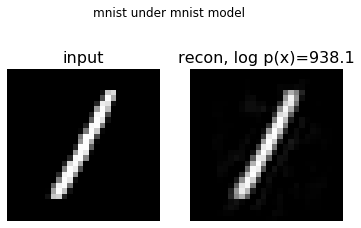

(array([954.0947], dtype=float32), array([-16.031925], dtype=float32)) 938.0628
[1200.8536]
[580.6338]
[311.88083]
[275.9449]
[275.9443]
[275.96454]
[275.97064]
[275.95593]
[275.94937]
[275.9501]


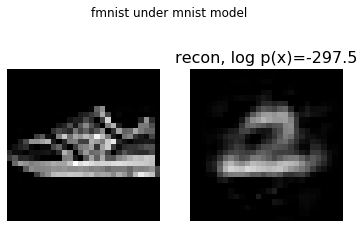

(array([-275.965], dtype=float32), array([-21.560543], dtype=float32)) -297.52554
[685.17194]
[-426.171]
[-428.18463]
[-428.19864]
[-428.2229]
[-428.22342]
[-428.20416]
[-428.19867]
[-428.22394]
[-428.208]


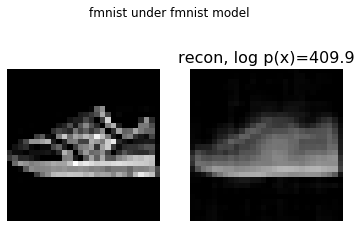

(array([428.21768], dtype=float32), array([-18.302063], dtype=float32)) 409.91562
[327.91437]
[172.12401]
[169.95915]
[169.95082]
[169.95688]
[169.95331]
[169.9534]
[169.98378]
[169.95328]
[169.95258]


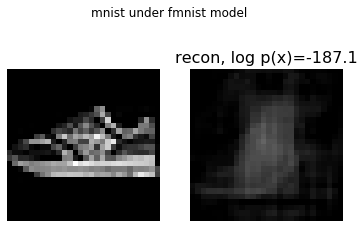

(array([-169.95593], dtype=float32), array([-17.158535], dtype=float32)) -187.11447


In [57]:
a = np.random.randint(low=0,high=10000)
losses =[]
for ii in range(10000):
    _, loss_ = sess.run([opt_op_MAP1,loss1], feed_dict={data1test:data_test['mnist'][a],data2test:data_test['fmnist'][a],datatype:'mnist'})
    losses.append(loss_)
    if ii%1000==0: 
        print(loss_)

plt.plot(np.convolve(np.asarray(losses)[:,0],np.ones((100))/100., mode='valid'),label='loss')

fwd_MAP,laplace = sess.run([fwd_pass1,lap1], feed_dict={data1test:data_test['mnist'][a],data2test:data_test['fmnist'][a],datatype:'mnist'})
plt.suptitle('mnist under mnist model')
plt.subplot(1,2,1)
plt.title('input')
plt.imshow(data_test['mnist'][a].reshape(28,28),cmap='gray',vmin=0, vmax=1)
plt.axis('off')
plt.subplot(1,2,2)
plt.title('recon, log p(x)=%.1f'%np.sum(laplace))
plt.imshow(fwd_MAP[0].reshape(28,28),cmap='gray',vmin=0, vmax=1)
plt.axis('off')
plt.show()

print(laplace, np.sum(laplace))

sess.run(MAP_reset)
losses =[]
for ii in range(10000):
    _, loss_ = sess.run([opt_op_MAP1,loss1], feed_dict={data1test:data_test['mnist'][a],data2test:data_test['fmnist'][a],datatype:'fmnist'})
    losses.append(loss_)
    if ii%1000==0: 
        print(loss_)

plt.plot(np.convolve(np.asarray(losses)[:,0],np.ones((100))/100., mode='valid'),label='loss')

fwd_MAP,laplace = sess.run([fwd_pass1,lap1], feed_dict={data1test:data_test['mnist'][a],data2test:data_test['fmnist'][a],datatype:'fmnist'})

plt.suptitle('fmnist under mnist model')
plt.subplot(1,2,1)
plt.imshow(data_test['fmnist'][a].reshape(28,28),cmap='gray',vmin=0, vmax=1)
plt.axis('off')
plt.subplot(1,2,2)
plt.title('recon, log p(x)=%.1f'%np.sum(laplace))
plt.imshow(fwd_MAP[0].reshape(28,28),cmap='gray',vmin=0, vmax=1)
plt.axis('off')
plt.show()

print(laplace, np.sum(laplace))

sess.run(MAP_reset)

losses =[]
for ii in range(10000):
    _, loss_ = sess.run([opt_op_MAP2,loss2], feed_dict={data1test:data_test['mnist'][a],data2test:data_test['fmnist'][a],datatype:'fmnist'})
    losses.append(loss_)
    if ii%1000==0: 
        print(loss_)

plt.plot(np.convolve(np.asarray(losses)[:,0],np.ones((100))/100., mode='valid'),label='loss')

fwd_MAP,laplace = sess.run([fwd_pass2,lap2], feed_dict={data1test:data_test['mnist'][a],data2test:data_test['fmnist'][a],datatype:'fmnist'})

plt.suptitle('fmnist under fmnist model')
plt.subplot(1,2,1)
plt.imshow(data_test['fmnist'][a].reshape(28,28),cmap='gray',vmin=0, vmax=1)
plt.axis('off')
plt.subplot(1,2,2)
plt.title('recon, log p(x)=%.1f'%np.sum(laplace))
plt.imshow(fwd_MAP[0].reshape(28,28),cmap='gray',vmin=0, vmax=1)
plt.axis('off')
plt.show()

print(laplace, np.sum(laplace))

sess.run(MAP_reset)
losses =[]
for ii in range(10000):
    _, loss_ = sess.run([opt_op_MAP2,loss2], feed_dict={data1test:data_test['mnist'][a],data2test:data_test['fmnist'][a],datatype:'mnist'})
    losses.append(loss_)
    if ii%1000==0: 
        print(loss_)

plt.plot(np.convolve(np.asarray(losses)[:,0],np.ones((100))/100., mode='valid'),label='loss')

fwd_MAP,laplace = sess.run([fwd_pass2,lap2], feed_dict={data1test:data_test['mnist'][a],data2test:data_test['fmnist'][a],datatype:'mnist'})
plt.suptitle('mnist under fmnist model')
plt.subplot(1,2,1)
plt.imshow(data_test['mnist'][a].reshape(28,28),cmap='gray',vmin=0, vmax=1)
plt.axis('off')
plt.subplot(1,2,2)
plt.title('recon, log p(x)=%.1f'%np.sum(laplace))
plt.imshow(fwd_MAP[0].reshape(28,28),cmap='gray',vmin=0, vmax=1)
plt.axis('off')
plt.show()

print(laplace, np.sum(laplace))

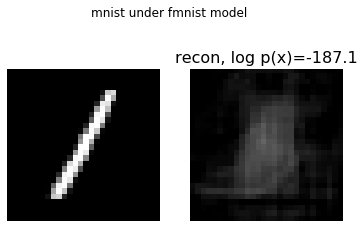

In [58]:
plt.suptitle('mnist under fmnist model')
plt.subplot(1,2,1)
plt.imshow(data_test['mnist'][a].reshape(28,28),cmap='gray',vmin=0, vmax=1)
plt.axis('off')
plt.subplot(1,2,2)
plt.title('recon, log p(x)=%.1f'%np.sum(laplace))
plt.imshow(fwd_MAP[0].reshape(28,28),cmap='gray',vmin=0, vmax=1)
plt.axis('off')
plt.show()

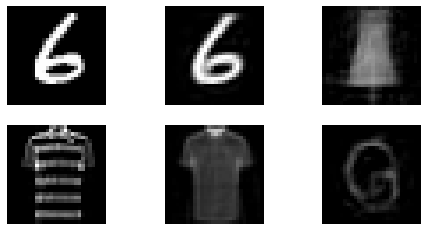

In [66]:
a = np.random.randint(low=0,high=10000)
jj=1
plt.figure(figsize=(4*2,2*2))
res = sess.run([data1test, recon11, recon21, data2test, recon22, recon12], feed_dict={data1test:data_test['mnist'][a],data2test:data_test['fmnist'][a]})
for jj in range(6):
    plt.subplot(2,3,jj+1)
    plt.imshow(res[jj][0].reshape(28,28),cmap='gray',vmin=0, vmax=1)
    plt.axis('off')

In [67]:
results=[]
aa = np.arange(0,10000)#np.unique(np.random.random_integers(low=0, high=len(data_test['mnist']), size=10000))
print(len(aa))
for a in aa:
    res = sess.run([var11,var12,var22, var21], feed_dict={data1test:data_test['mnist'][a],data2test:data_test['fmnist'][a]})
    results.append(res)
results=np.asarray(res).reshape((4,-1))

10000


Text(0.5, 0, 'approx. posterior sigma')

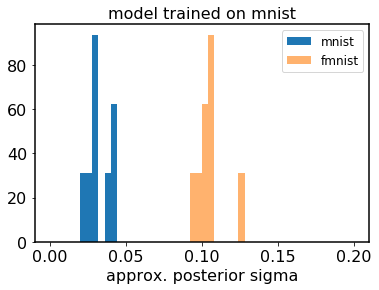

In [71]:
#decoder trained on mnist
plt.title('model trained on mnist')
_, bins, _= plt.hist(results[0], label='mnist',range=(0,0.2),density=True,bins=50)
_=plt.hist(results[1], alpha=0.6,label='fmnist', density=True, bins=bins)
plt.legend()
plt.xlabel('approx. posterior sigma')

Text(0.5, 0, 'approx. posterior sigma')

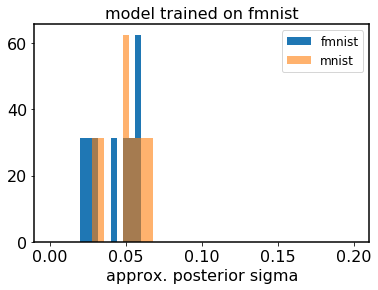

In [72]:
#decoder trained on mnist
plt.title('model trained on fmnist')
_, bins, _= plt.hist(results[2], label='fmnist',range=(0,0.2),density=True,bins=50)
_=plt.hist(results[3], alpha=0.6,label='mnist', density=True, bins=bins)
plt.legend()
plt.xlabel('approx. posterior sigma')

In [60]:
p11, p12, p21, p22 = [], [], [], []
p11t, p12t, p21t, p22t = [], [], [], []

aa = np.arange(0,10000)#np.unique(np.random.random_integers(low=0, high=len(data_test['mnist']), size=10000))
print(len(aa))
for a in aa:
    p11_, p12_, p21_, p22_= sess.run([rms11, rms12, rms21, rms22], feed_dict={data1test:data_test['mnist'][a],data2test:data_test['fmnist'][a]})
    p11+=[p11_]
    p12+=[p12_]
    p21+=[p21_]
    p22+=[p22_]

10000


In [61]:
print(np.mean(p11))
print(np.mean(p22))

0.10673926
0.10155665


Text(0.5, 0, 'rms(x-recon)')

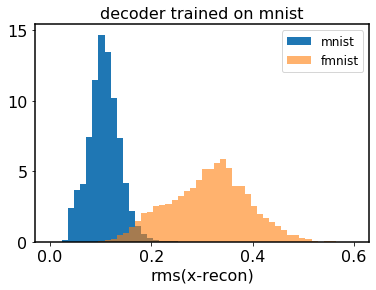

In [62]:
#decoder trained on mnist
plt.title('decoder trained on mnist')
_, bins, _=plt.hist(p11, label='mnist',density=True, range=(0,0.6),bins=50)
_=plt.hist(p12, alpha=0.6,label='fmnist', density=True, bins=bins)
plt.legend()
plt.xlabel('rms(x-recon)')

Text(0.5, 0, 'rms(x-recon)')

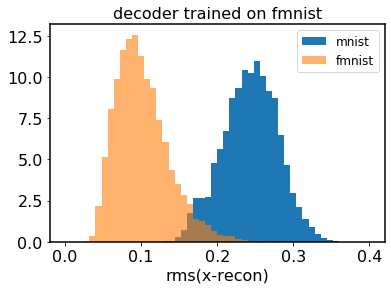

In [45]:
#decoder trained on mnist
plt.title('decoder trained on fmnist')
_, bins, _=plt.hist(p21, label='mnist',density=True, range=(0,0.4), bins=50)
_=plt.hist(p22, alpha=0.6,label='fmnist', density=True, bins=bins)
plt.legend()
plt.xlabel('rms(x-recon)')

In [51]:
aa = np.unique(np.random.random_integers(low=0, high=len(data_test['mnist']), size=1200))
print(len(aa))
for a in aa:
    p11_, p12_, p21_, p22_= sess.run([prob11, prob12, prob21, prob22], feed_dict={data1test:data_test['mnist'][a],data2test:data_test['fmnist'][a]})
    p11+=[p11_]
    p12+=[p12_]
    p21+=[p21_]
    p22+=[p22_]
    p11t_, p12t_, p21t_, p22t_= sess.run([prob11_, prob12_, prob21_, prob22_], feed_dict={data1train:data_train['mnist'][a],data2train:data_train['fmnist'][a]})
    p11t+=[p11t_]
    p12t+=[p12t_]
    p21t+=[p21t_]
    p22t+=[p22t_]

/home/nessa/miniconda3/envs/tflow/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: This function is deprecated. Please call randint(0, 50000 + 1) instead
  """Entry point for launching an IPython kernel.


1189


Text(0.5, 0, 'log p(x)')

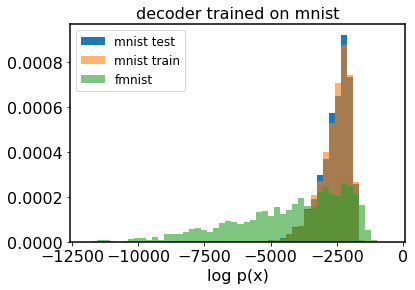

In [52]:
#decoder trained on mnist
plt.title('decoder trained on mnist')
_, bins, _=plt.hist(p11, label='mnist test',density=True, range=(-12000,-500), bins=50)
_=plt.hist(p11t, alpha=0.6,label='mnist train', density=True, bins=bins)
_=plt.hist(p12, alpha=0.6,label='fmnist', density=True, bins=bins)
plt.legend()
plt.xlabel('log p(x)')

Text(0.5, 0, 'log p(x)')

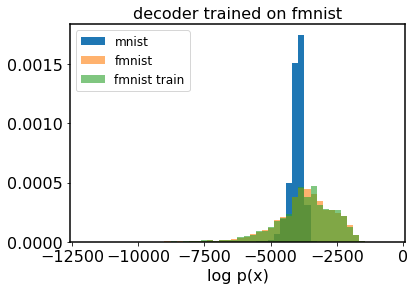

In [53]:
#decoder trained on mnist
plt.title('decoder trained on fmnist')
_, bins, _=plt.hist(p21, label='mnist',density=True, range=(-12000,-500), bins=50)
_=plt.hist(p22, alpha=0.6,label='fmnist', density=True, bins=bins)
_=plt.hist(p22t, alpha=0.6,label='fmnist train', density=True, bins=bins)
plt.legend()
plt.xlabel('log p(x)')

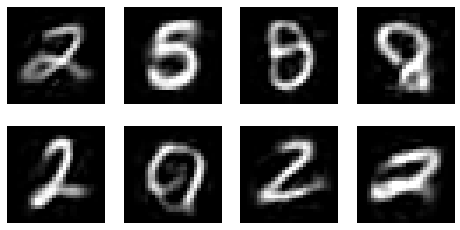

In [61]:
x_sample=sess.run(x_samples1)
jj=1
plt.figure(figsize=(4*2,2*2))
for ii in range(8):
    plt.subplot(2,4,jj)
    plt.imshow(x_sample[ii].reshape(28,28),cmap='gray',vmin=0, vmax=1)
    plt.axis('off')
    jj+=1

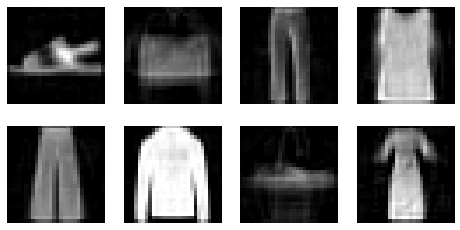

In [73]:
x_sample=sess.run(x_samples2)
jj=1
plt.figure(figsize=(4*2,2*2))
for ii in range(8):
    plt.subplot(2,4,jj)
    plt.imshow(x_sample[ii].reshape(28,28),cmap='gray',vmin=0, vmax=1)
    plt.axis('off')
    jj+=1